In [18]:
import math
import matplotlib.pyplot as plt
import random
import numpy as np

## Capture probability function

In [80]:
# only consider x capture
def P_cap(Px, Py, CR):
    # calculate power ratio threshold
    Pr = 10 ** (CR / 10)
    
    slope_1 = math.sqrt(Py * Pr / Px)

    if slope_1 >= 1:
        result = (1 / math.sqrt(Pr * Py / Px) / 2)
    elif slope_1 < 1:
        result = 1 - math.sqrt(Pr * Py / Px) / 2
    return result

In [81]:
def getPower(n, step, scheme):
    if scheme == 1:
        power_sum = 0
        for i in range(step):
            power_sum += 2 ** (i if i <= (step - 1) else (step - 1))
        return power_sum / step
    else:
        return 2 ** (n-1 if n-1 <= (step - 1) else (step - 1))

In [132]:
# sta_amount: Total contend stations number
# RA_RU: RA_RU number reserved for UORA
# Lmax: Retransmit limit
# TXOP: Transaction Opportunity (time length in ms)
# ocw_min: minimum OCW
# ocw_max: maximum OCW
# CR: Capture Ratio (CR=infinite = no capture, CR=0 = always capture)

def analytical(sta_amount, RA_RU, Lmax, TXOP, ocw_min, ocw_max, CR, step):
    access_delay=0
    counter_delay_slot=0
    success_sta=0
    success_packet=0
    success_probability=0
    # setting ocw for each transmission [ocw_min, 1st_retry_ocw...ocw_max]
    ocw = [0 for _ in range(0, Lmax+1) ]
    ocw[1] = ocw_min
    for n in range (2, Lmax+1):
        temp_ocw = ocw[n-1] * 2 + 1
        if temp_ocw <= ocw_max:
            ocw[n] = temp_ocw
        else:
            ocw[n] = ocw[n-1]
    # Imax: Reserved slot for transmission (total slots in worst case)
    Imax = 0
    for z in range(1,Lmax+1):
        Imax += math.ceil(ocw[z] / RA_RU)
    # Ri: RA_RU number i-th slot, (Ri[i])
    Ri = [RA_RU for _ in range(0,Imax+1)]
    # M: Arrival number for i-th slot, (M[i])
    M  = [0 for _ in range(0,Imax+1)]
    # M_i: Arrival number for i-th slot and n-th transmission (M_i[n])
    M_i    = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_s  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Fail stations for i-th slot and n-th transmission (M_i_s[n])
    M_i_f  = [ [0] * (Lmax+1) for _ in range(0, Imax+1)]
    # M_i_s: Average Success stations for i-th slot (M_i_s_C[i])
    M_i_s_C = [0 for _ in range(0,Imax+1)]
    
    M_i_s_ana  = [ 0 for _ in range(0, Imax)]
    

    for i in range (1,Imax+1):
        # calculate Mi[n], a_k_i
        for n in range (1, Lmax+1):
            # a_k_i: the portion of STAs that fail their (n − 1)th packet transmissions in the kth 
            # slot and transmit the packet for the nth time in the ith slot (k < i)
            if n == 1:
                if i == 1:
                    M_i[i][n] = min((Ri[i]+1) / (ocw[n]+1), 1) * sta_amount
                elif i >= 2 and i <= math.floor(ocw[n] / Ri[i]):
                    M_i[i][n] = Ri[i] / (ocw[n] + 1) * sta_amount
                elif i == math.ceil(ocw[n] / Ri[i]):
                    M_i[i][n] = (ocw[n] - Ri[i] * math.floor(ocw[n] / Ri[i])) / (ocw[n] + 1) * sta_amount
                else:
                    M_i[i][n] = 0
            elif n <= i:
                #/** Mi[n]=sigma (a_j_i*Mi_F[n-1]) */ 
                for k in range (1, i):
                    if ocw[n] <= Ri[i]:
                        if k == i-1:
                            a_k_i = 1
                        else:
                            a_k_i = 0
                    elif ocw[n] > Ri[i]:
                        if k == (i - math.ceil(ocw[n] / Ri[i])):
                            a_k_i = (ocw[n] - Ri[i] * (math.ceil(ocw[n] / Ri[i]) - 1)) / (ocw[n] + 1)
                        elif k <= (i-2) and k >= (i - math.ceil(ocw[n] / Ri[i]) + 1):
                            a_k_i = Ri[i] / (ocw[n] + 1)
                        elif k == (i - 1):
                            a_k_i = (Ri[i] + 1) / (ocw[n] + 1)
                        else:
                            a_k_i = 0
                    
                    M_i[i][n] += a_k_i * M_i_f[k][n-1]
            M[i] += M_i[i][n]
            
        #/** statistics */  
        for n in range (1, Lmax+1):
            if M[i] <= 0:
                break
#             print(f'{M_i[i][n]} * math.exp(-{M[i]} / {Ri[i]})')
            first_term = M_i[i][n] * math.exp(-M[i] / Ri[i])
            temp_sum = 0
            Pn = getPower(n=n, step=step, scheme=2)
            for k in range(1, Lmax+1):
                Pk = getPower(n=k, step=step, scheme=2)
                temp_sum += P_cap(Pn, Pk, CR) * (M_i[i][k] / M[i])

#             second_term = (M[i] ** 2) / Ri[i] * math.exp(-M[i] / Ri[i])
            second_term = (M[i] ** 2) / Ri[i] * math.exp(-M[i] / Ri[i]) * temp_sum * (M_i[i][n] / M[i])
            
            if M[i] >= 2:
                M_i_s[i][n] = first_term + second_term
            else:
                M_i_s[i][n] = first_term
#             print(f'first_term={first_term}, second_term={second_term}, temp_sum={temp_sum}')
#             print(f'R={Ri[i]}, n={n}, M[i]={M[i]}, M_i[i][n]={M_i[i][n]}, M_i_s[i][n]={M_i_s[i][n]}')
            M_i_s_ana[i-1] += M_i_s[i][n]
            M_i_f[i][n] = M_i[i][n] - M_i_s[i][n]
#             if M_i_f[i][n] < 0:
#                 M_i_f[i][n] = 0 
            M_i_s_C[i] += M_i_s[i][n]
#             if M_i[i][n] < 0 or M_i_s[i][n] < 0 or M_i_f[i][n] < 0:
#                 print(f'i={i}, n={n}, capture_prob={capture_prob}, M_i[i][n]={M_i[i][n]}, M_i_s[i][n]={M_i_s[i][n]}, M_i_f[i][n]={M_i_f[i][n]}')
        #/** performance metric */  
        success_packet += M_i_s_C[i]
        success_sta += M_i_s_C[i]
        counter_delay_slot += M_i_s_C[i] * i
    
    #/** success probability */
    success_probability = success_packet / sta_amount
        
    access_delay = (TXOP * counter_delay_slot) / success_packet
#     Throughput 
    through_put = success_packet / Imax
#     Utilization
    utilization = success_packet / (Imax * RA_RU)

#     print(Imax,success_probability,access_delay, utilization, through_put)
#     print(type(Imax),type(success_probability),type(access_delay), type(utilization), type(through_put))
    
    return Imax,success_probability,access_delay, utilization, through_put, M_i_s_ana  # ,sta*success_probability

# CR=1.5

In [106]:
R = [9,18,37,74,148]
Lmax = 5
# sta_max = 200
sta_max = 1000
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

# for r in R:
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=1.5, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U

In [107]:
# Simulation (old -> m=200)

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
# m_list_simu = [(i+1)*10 for i in range(20)]
m_list_simu = np.concatenate([np.arange(1, 11, 1), np.arange(20, 110, 10), np.arange(200, 1100, 100)])

ps_list_simu_9 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997500000000001, 0.9906333333333339, 0.9365500000000032, 0.8104599999999997, 0.6537666666666655, 0.5040285714285715, 0.39343749999999966, 0.3103888888888887, 0.24968999999999994, 0.07223999999999996, 0.0408600000000001, 0.027724999999999975, 0.02031799999999985, 0.01645666666666669, 0.013148571428571405, 0.01128624999999997, 0.009586666666666625, 0.008474999999999955]
da_list_simu_9 = [5.672999999999856, 6.203425499999861, 6.777343999999894, 7.16783549999996, 7.641531000000006, 8.22963199999996, 8.704002857142816, 9.28528275000002, 9.865346999999968, 10.489377000000033, 17.25281717368432, 24.916865934537473, 31.93834846714585, 37.39170788631537, 41.54234959721159, 45.13303234684957, 48.111577401678346, 51.13718646390864, 53.505465715337266, 67.45158357947722, 70.97925346068722, 72.70638543334549, 73.98591073610562, 74.84455550378766, 75.59048797785557, 76.2668632750841, 76.75537448699653, 77.22202204486373]
t_list_simu_9 = [0.06666666666666801, 0.13333333333333602, 0.19999999999999718, 0.26666666666667205, 0.3333333333333318, 0.39999999999999436, 0.46666666666665557, 0.5333333333333441, 0.6000000000000113, 0.6666666666666636, 1.3329999999999942, 1.9812666666666678, 2.4974666666666594, 2.7015333333333293, 2.615066666666662, 2.352133333333336, 2.0983333333333345, 1.8623333333333318, 1.6645999999999992, 0.9631999999999996, 0.8171999999999993, 0.7393333333333353, 0.6772666666666675, 0.6582666666666684, 0.6136000000000027, 0.6019333333333348, 0.5752000000000026, 0.5650000000000021]
u_list_simu_9 = [0.007407407407407279, 0.014814814814814559, 0.02222222222222215, 0.029629629629629117, 0.0370370370370375, 0.0444444444444443, 0.051851851851851004, 0.059259259259258235, 0.06666666666666801, 0.074074074074075, 0.14811111111111294, 0.2201407407407438, 0.27749629629629624, 0.3001703703703697, 0.29056296296296263, 0.2613481481481481, 0.2331481481481486, 0.20692592592592615, 0.18495555555555532, 0.10702222222222241, 0.09079999999999992, 0.0821481481481481, 0.07525185185185193, 0.07314074074074088, 0.06817777777777789, 0.06688148148148154, 0.06391111111111124, 0.0627777777777779]
power_list_simu_9 = [1.0, 1.13, 1.2920000000000007, 1.3985, 1.5180000000000062, 1.6733333333333287, 1.7942857142857205, 1.9665, 2.131111111111112, 2.3099999999999983, 4.587200000000002, 8.13181626457832, 12.893502792998666, 19.361860467881232, 28.13428326653958, 40.26430002141862, 54.4541884016563, 71.50305518095517, 91.03709232626463, 332.56409172434246, 596.1172343428163, 883.9880791959664, 1216.0898432397676, 1510.6406832246146, 1880.2375276945395, 2220.1952742029207, 2597.044655344659, 3009.718242868236]


ps_list_simu_18 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997, 0.9959250000000023, 0.9683000000000069, 0.8849333333333322, 0.7459857142857141, 0.6031375000000011, 0.47375555555555526, 0.3725799999999999, 0.07722999999999974, 0.03932333333333342, 0.026347499999999947, 0.01888399999999989, 0.014115000000000077, 0.010548571428571407, 0.007580000000000006, 0.005599999999999983, 0.004144999999999964]
da_list_simu_18 = [5.672999999999856, 5.857372499999863, 6.096583999999883, 6.274337999999922, 6.391201799999945, 6.642137499999911, 6.743576142857092, 6.982044750000018, 7.1977763333333415, 7.338592800000035, 9.673032300000058, 12.849944903448264, 16.36901748375379, 20.029016863930217, 23.284629739348436, 25.755547567297057, 27.74910727730913, 29.449005093209934, 30.939722729478408, 41.377611882970946, 44.27726381042499, 45.05867541637226, 45.2801723087986, 45.349994571419145, 45.37681174415471, 45.38124229166552, 45.38399999999885, 45.383999999998856]
t_list_simu_18 = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 2.5, 3.748875, 4.979625, 6.051875, 6.637, 6.527375, 6.031375, 5.32975, 4.65725, 1.93075, 1.474625, 1.317375, 1.18025, 1.058625, 0.923, 0.758, 0.63, 0.518125]
u_list_simu_18 = [0.0069444444444445785, 0.013888888888889157, 0.02083333333333324, 0.027777777777778314, 0.03472222222222164, 0.04166666666666648, 0.048611111111111965, 0.05555555555555663, 0.0625, 0.06944444444444328, 0.13888888888888656, 0.2082708333333358, 0.27664583333332954, 0.3362152777777785, 0.36872222222222245, 0.3626319444444445, 0.3350763888888887, 0.29609722222222207, 0.25873611111111167, 0.1072638888888892, 0.0819236111111109, 0.07318749999999971, 0.0655694444444444, 0.05881250000000009, 0.05127777777777793, 0.04211111111111119, 0.03500000000000005, 0.02878472222222221]
power_list_simu_18 = [1.0, 1.065, 1.1513333333333324, 1.2135, 1.260400000000001, 1.347333333333333, 1.384857142857147, 1.47475, 1.5575555555555447, 1.6180000000000059, 2.6230000000000033, 4.308257471264373, 6.720852764708031, 10.123881175912684, 14.909056245022354, 21.73065725233205, 30.569013172192758, 42.33351050740039, 56.8186760027709, 310.86079460414345, 615.4903284588493, 918.9022634054627, 1300.0947698135183, 1753.5201531801495, 2385.579300699307, 3457.1044444444337, 4906.722922077915, 6936.900396825415]


ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99992, 0.9997333333333334, 0.9970285714285702, 0.9860499999999989, 0.9507222222222222, 0.87018, 0.08017499999999994, 0.006369999999999978, 0.0004800000000000004, 3.600000000000002e-05, 0.0, 0.0, 0.0, 0.0, 0.0]
da_list_simu_37 = [5.672999999999856, 5.746748999999861, 5.865881999999871, 5.904174749999882, 6.0065723999999046, 6.116439499999875, 6.242731285714212, 6.298448249999973, 6.351868999999943, 6.432047400000011, 7.370928900000033, 8.320589100000001, 9.40356480000008, 10.583019320000005, 11.988036244629157, 13.48833578034307, 15.086933230991567, 16.491032664086163, 17.6180273913173, 17.628874535280406, 16.93844067320587, 17.3378964497041, 19.22516666666667, 19.22516666666667, 19.22516666666667, 19.22516666666667, 19.22516666666667, 19.22516666666667]
t_list_simu_37 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 9.9992, 11.996799999999995, 13.9584, 15.776799999999982, 17.112999999999996, 17.40360000000003, 3.207000000000002, 0.38219999999999815, 0.038400000000000004, 0.0036000000000000008, 0.0, 0.0, 0.0, 0.0, 0.0]
u_list_simu_37 = [0.005405405405405471, 0.010810810810810942, 0.016216216216216387, 0.021621621621621883, 0.02702702702702728, 0.032432432432432774, 0.03783783783783734, 0.043243243243243766, 0.048648648648649366, 0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.27024864864864423, 0.3242378378378365, 0.3772540540540569, 0.4264000000000021, 0.462513513513514, 0.47036756756756776, 0.08667567567567544, 0.010329729729729774, 0.0010378378378378351, 9.729729729729731e-05, 0.0, 0.0, 0.0, 0.0, 0.0]
power_list_simu_37 = [1.0, 1.026, 1.0733333333333326, 1.0815, 1.1175999999999986, 1.1586666666666674, 1.2057142857142904, 1.22675, 1.244666666666656, 1.2730000000000083, 1.6504000000000003, 2.0908000000000007, 2.691150000000002, 3.475739999999996, 4.5769246988013546, 5.990931762292154, 7.857252221647033, 10.24261451462385, 13.787847923087055, 292.0609230680889, 3432.278304761902, 1459.0803333333333, 206.8, 0.0, 0.0, 0.0, 0.0, 0.0]


ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999750000000001, 1.0, 1.0, 0.8696350000000002, 0.29875666666666634, 0.08158500000000013, 0.022833999999999837, 0.006775000000000003, 0.0018385714285714208, 0.0004937499999999967, 0.00013666666666666642, 4.400000000000003e-05]
da_list_simu_74 = [5.672999999999856, 5.724056999999859, 5.7391849999998605, 5.810570249999873, 5.856805199999886, 5.894246999999871, 5.921801571428469, 5.990687999999925, 6.03039899999991, 6.074081099999944, 6.4944504000000265, 6.958879999999992, 7.428793500000027, 7.867543320000006, 8.359260050000017, 8.882216099999988, 9.430820655769297, 10.05482519999999, 10.625358810000005, 17.64926796320066, 18.40445787061529, 17.629084762273138, 17.293715797629822, 17.1663190361806, 16.984987584560223, 16.952519531249926, 15.654191304347828, 16.755139534883725]
t_list_simu_74 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 15.999600000000001, 18.0, 20.0, 34.78540000000002, 17.925400000000028, 6.526799999999994, 2.2834, 0.8130000000000007, 0.2573999999999991, 0.07900000000000043, 0.02459999999999995, 0.008800000000000002]
u_list_simu_74 = [0.0027027027027027354, 0.005405405405405471, 0.008108108108108194, 0.010810810810810942, 0.01351351351351364, 0.016216216216216387, 0.01891891891891867, 0.021621621621621883, 0.024324324324324683, 0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621081081081284, 0.24324324324324892, 0.27027027027026584, 0.4700729729729731, 0.2422351351351351, 0.08820000000000004, 0.030856756756756934, 0.010986486486486497, 0.0034783783783783936, 0.0010675675675675615, 0.0003324324324324317, 0.00011891891891891892]
power_list_simu_74 = [1.0, 1.018, 1.023333333333333, 1.0485, 1.0679999999999987, 1.0786666666666678, 1.0882857142857172, 1.112, 1.126444444444437, 1.1430000000000058, 1.2972000000000021, 1.4750666666666667, 1.6737499999999985, 1.87052, 2.1095666666666655, 2.3849428571428577, 2.711435897435898, 3.103222222222221, 3.4966000000000004, 13.79253758401737, 65.89406466546325, 277.0603854291076, 1101.672413586954, 4323.120085425684, 8031.077395238097, 5256.636, 2302.9306666666666, 976.912]


ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99996, 0.9935500000000045, 0.8690474999999998, 0.5572599999999991, 0.3019716666666668, 0.15624999999999997, 0.08233000000000001, 0.04337222222222215, 0.023324999999999884]
da_list_simu_148 = [5.672999999999856, 5.690018999999857, 5.7070379999998595, 5.741075999999864, 5.752421999999867, 5.775113999999863, 5.812393714285593, 5.820497999999898, 5.82238899999988, 5.868151199999914, 6.0998932499999965, 6.316129100000008, 6.519411600000019, 6.736233660000025, 6.970131449999992, 7.1927966999999855, 7.402484962500039, 7.652057566666682, 7.906573559999999, 10.684774469131286, 14.375986442177739, 17.638093074818205, 18.588470528632804, 18.40726829379332, 17.986446106067632, 17.688559753784425, 17.460500930005747, 17.32205328607268]
t_list_simu_148 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.998400000000004, 59.61300000000006, 69.52380000000008, 55.72599999999996, 36.236599999999946, 21.87499999999998, 13.172799999999985, 7.806999999999997, 4.664999999999996]
u_list_simu_148 = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.27025945945945506, 0.4027905405405404, 0.4697554054054055, 0.3765270270270274, 0.24484189189189187, 0.14780405405405408, 0.08900540540540526, 0.05274999999999994, 0.031520270270270254]
power_list_simu_148 = [1.0, 1.006, 1.0119999999999998, 1.024, 1.0279999999999991, 1.0360000000000007, 1.0497142857142878, 1.052, 1.0526666666666624, 1.0694000000000037, 1.1520000000000035, 1.2306666666666746, 1.306050000000001, 1.3870800000000048, 1.4798999999999989, 1.5712285714285736, 1.6602250000000007, 1.770955555555557, 1.887779999999999, 3.543083580021316, 6.951077357744216, 13.770513353647111, 29.772934821747388, 64.70200428718573, 136.17034966946625, 270.5104537941288, 530.3491266485989, 1015.8448645289781]

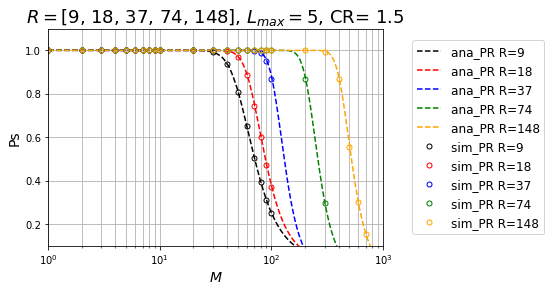

In [108]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.semilogx(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

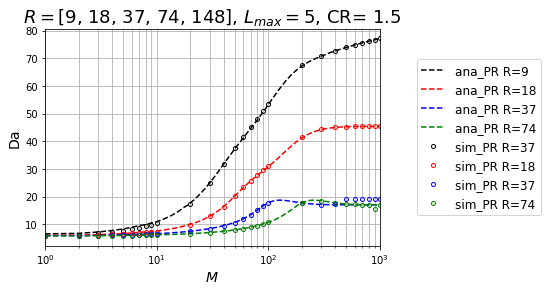

In [109]:
# plt.plot(m_list, da_list[0], color='black', label='ana R=9')
# plt.plot(m_list, da_list[1], color='red', label='ana R=18')
# plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
# plt.plot(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
# plt.plot(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.xlim(1, sta_max)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

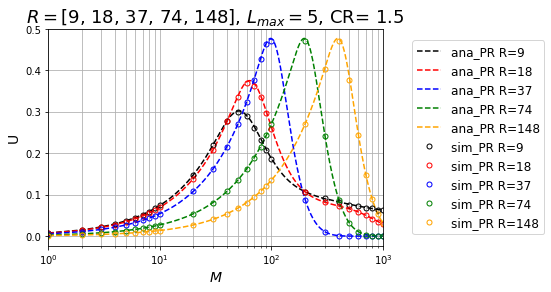

In [110]:
# plt.plot(m_list, u_list[0], color='black', label='ana R=9')
# plt.plot(m_list, u_list[1], color='red', label='ana R=18')
# plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.semilogx(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 1.5', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.xlim(1, sta_max)

plt.show()

# CR=3

In [111]:
R = [9,18,37,74,148]
Lmax = 5
# sta_max = 200
sta_max = 1000
m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

MiS_list = [ [0] * (sta_max) for _ in range(0, len(R))]
for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp, MiS = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=3, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U
        MiS_list[idx][sta-1] = 

In [112]:
# Simulation (old -> m=200)

# m_list_simu = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
# m_list_simu = [(i+1)*10 for i in range(20)]
m_list_simu = np.concatenate([np.arange(1, 11, 1), np.arange(20, 110, 10), np.arange(200, 1100, 100)])

ps_list_simu_9 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997500000000001, 0.9906333333333339, 0.9365500000000032, 0.8104599999999997, 0.6537666666666655, 0.5040285714285715, 0.39343749999999966, 0.3103888888888887, 0.24968999999999994, 0.07223999999999996, 0.0408600000000001, 0.027724999999999975, 0.02031799999999985, 0.01645666666666669, 0.013148571428571405, 0.01128624999999997, 0.009586666666666625, 0.008474999999999955]
da_list_simu_9 = [5.672999999999856, 6.203425499999861, 6.777343999999894, 7.16783549999996, 7.641531000000006, 8.22963199999996, 8.704002857142816, 9.28528275000002, 9.865346999999968, 10.489377000000033, 17.25281717368432, 24.916865934537473, 31.93834846714585, 37.39170788631537, 41.54234959721159, 45.13303234684957, 48.111577401678346, 51.13718646390864, 53.505465715337266, 67.45158357947722, 70.97925346068722, 72.70638543334549, 73.98591073610562, 74.84455550378766, 75.59048797785557, 76.2668632750841, 76.75537448699653, 77.22202204486373]
t_list_simu_9 = [0.06666666666666801, 0.13333333333333602, 0.19999999999999718, 0.26666666666667205, 0.3333333333333318, 0.39999999999999436, 0.46666666666665557, 0.5333333333333441, 0.6000000000000113, 0.6666666666666636, 1.3329999999999942, 1.9812666666666678, 2.4974666666666594, 2.7015333333333293, 2.615066666666662, 2.352133333333336, 2.0983333333333345, 1.8623333333333318, 1.6645999999999992, 0.9631999999999996, 0.8171999999999993, 0.7393333333333353, 0.6772666666666675, 0.6582666666666684, 0.6136000000000027, 0.6019333333333348, 0.5752000000000026, 0.5650000000000021]
u_list_simu_9 = [0.007407407407407279, 0.014814814814814559, 0.02222222222222215, 0.029629629629629117, 0.0370370370370375, 0.0444444444444443, 0.051851851851851004, 0.059259259259258235, 0.06666666666666801, 0.074074074074075, 0.14811111111111294, 0.2201407407407438, 0.27749629629629624, 0.3001703703703697, 0.29056296296296263, 0.2613481481481481, 0.2331481481481486, 0.20692592592592615, 0.18495555555555532, 0.10702222222222241, 0.09079999999999992, 0.0821481481481481, 0.07525185185185193, 0.07314074074074088, 0.06817777777777789, 0.06688148148148154, 0.06391111111111124, 0.0627777777777779]
power_list_simu_9 = [1.0, 1.13, 1.2920000000000007, 1.3985, 1.5180000000000062, 1.6733333333333287, 1.7942857142857205, 1.9665, 2.131111111111112, 2.3099999999999983, 4.587200000000002, 8.13181626457832, 12.893502792998666, 19.361860467881232, 28.13428326653958, 40.26430002141862, 54.4541884016563, 71.50305518095517, 91.03709232626463, 332.56409172434246, 596.1172343428163, 883.9880791959664, 1216.0898432397676, 1510.6406832246146, 1880.2375276945395, 2220.1952742029207, 2597.044655344659, 3009.718242868236]


ps_list_simu_18 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997, 0.9959250000000023, 0.9683000000000069, 0.8849333333333322, 0.7459857142857141, 0.6031375000000011, 0.47375555555555526, 0.3725799999999999, 0.07722999999999974, 0.03932333333333342, 0.026347499999999947, 0.01888399999999989, 0.014115000000000077, 0.010548571428571407, 0.007580000000000006, 0.005599999999999983, 0.004144999999999964]
da_list_simu_18 = [5.672999999999856, 5.857372499999863, 6.096583999999883, 6.274337999999922, 6.391201799999945, 6.642137499999911, 6.743576142857092, 6.982044750000018, 7.1977763333333415, 7.338592800000035, 9.673032300000058, 12.849944903448264, 16.36901748375379, 20.029016863930217, 23.284629739348436, 25.755547567297057, 27.74910727730913, 29.449005093209934, 30.939722729478408, 41.377611882970946, 44.27726381042499, 45.05867541637226, 45.2801723087986, 45.349994571419145, 45.37681174415471, 45.38124229166552, 45.38399999999885, 45.383999999998856]
t_list_simu_18 = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 2.5, 3.748875, 4.979625, 6.051875, 6.637, 6.527375, 6.031375, 5.32975, 4.65725, 1.93075, 1.474625, 1.317375, 1.18025, 1.058625, 0.923, 0.758, 0.63, 0.518125]
u_list_simu_18 = [0.0069444444444445785, 0.013888888888889157, 0.02083333333333324, 0.027777777777778314, 0.03472222222222164, 0.04166666666666648, 0.048611111111111965, 0.05555555555555663, 0.0625, 0.06944444444444328, 0.13888888888888656, 0.2082708333333358, 0.27664583333332954, 0.3362152777777785, 0.36872222222222245, 0.3626319444444445, 0.3350763888888887, 0.29609722222222207, 0.25873611111111167, 0.1072638888888892, 0.0819236111111109, 0.07318749999999971, 0.0655694444444444, 0.05881250000000009, 0.05127777777777793, 0.04211111111111119, 0.03500000000000005, 0.02878472222222221]
power_list_simu_18 = [1.0, 1.065, 1.1513333333333324, 1.2135, 1.260400000000001, 1.347333333333333, 1.384857142857147, 1.47475, 1.5575555555555447, 1.6180000000000059, 2.6230000000000033, 4.308257471264373, 6.720852764708031, 10.123881175912684, 14.909056245022354, 21.73065725233205, 30.569013172192758, 42.33351050740039, 56.8186760027709, 310.86079460414345, 615.4903284588493, 918.9022634054627, 1300.0947698135183, 1753.5201531801495, 2385.579300699307, 3457.1044444444337, 4906.722922077915, 6936.900396825415]


ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99992, 0.9997333333333334, 0.9970285714285702, 0.9860499999999989, 0.9507222222222222, 0.87018, 0.08017499999999994, 0.006369999999999978, 0.0004800000000000004, 3.600000000000002e-05, 0.0, 0.0, 0.0, 0.0, 0.0]
da_list_simu_37 = [5.672999999999856, 5.746748999999861, 5.865881999999871, 5.904174749999882, 6.0065723999999046, 6.116439499999875, 6.242731285714212, 6.298448249999973, 6.351868999999943, 6.432047400000011, 7.370928900000033, 8.320589100000001, 9.40356480000008, 10.583019320000005, 11.988036244629157, 13.48833578034307, 15.086933230991567, 16.491032664086163, 17.6180273913173, 17.628874535280406, 16.93844067320587, 17.3378964497041, 19.22516666666667, 19.22516666666667, 19.22516666666667, 19.22516666666667, 19.22516666666667, 19.22516666666667]
t_list_simu_37 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 9.9992, 11.996799999999995, 13.9584, 15.776799999999982, 17.112999999999996, 17.40360000000003, 3.207000000000002, 0.38219999999999815, 0.038400000000000004, 0.0036000000000000008, 0.0, 0.0, 0.0, 0.0, 0.0]
u_list_simu_37 = [0.005405405405405471, 0.010810810810810942, 0.016216216216216387, 0.021621621621621883, 0.02702702702702728, 0.032432432432432774, 0.03783783783783734, 0.043243243243243766, 0.048648648648649366, 0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21621621621621823, 0.27024864864864423, 0.3242378378378365, 0.3772540540540569, 0.4264000000000021, 0.462513513513514, 0.47036756756756776, 0.08667567567567544, 0.010329729729729774, 0.0010378378378378351, 9.729729729729731e-05, 0.0, 0.0, 0.0, 0.0, 0.0]
power_list_simu_37 = [1.0, 1.026, 1.0733333333333326, 1.0815, 1.1175999999999986, 1.1586666666666674, 1.2057142857142904, 1.22675, 1.244666666666656, 1.2730000000000083, 1.6504000000000003, 2.0908000000000007, 2.691150000000002, 3.475739999999996, 4.5769246988013546, 5.990931762292154, 7.857252221647033, 10.24261451462385, 13.787847923087055, 292.0609230680889, 3432.278304761902, 1459.0803333333333, 206.8, 0.0, 0.0, 0.0, 0.0, 0.0]


ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999750000000001, 1.0, 1.0, 0.8696350000000002, 0.29875666666666634, 0.08158500000000013, 0.022833999999999837, 0.006775000000000003, 0.0018385714285714208, 0.0004937499999999967, 0.00013666666666666642, 4.400000000000003e-05]
da_list_simu_74 = [5.672999999999856, 5.724056999999859, 5.7391849999998605, 5.810570249999873, 5.856805199999886, 5.894246999999871, 5.921801571428469, 5.990687999999925, 6.03039899999991, 6.074081099999944, 6.4944504000000265, 6.958879999999992, 7.428793500000027, 7.867543320000006, 8.359260050000017, 8.882216099999988, 9.430820655769297, 10.05482519999999, 10.625358810000005, 17.64926796320066, 18.40445787061529, 17.629084762273138, 17.293715797629822, 17.1663190361806, 16.984987584560223, 16.952519531249926, 15.654191304347828, 16.755139534883725]
t_list_simu_74 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 15.999600000000001, 18.0, 20.0, 34.78540000000002, 17.925400000000028, 6.526799999999994, 2.2834, 0.8130000000000007, 0.2573999999999991, 0.07900000000000043, 0.02459999999999995, 0.008800000000000002]
u_list_simu_74 = [0.0027027027027027354, 0.005405405405405471, 0.008108108108108194, 0.010810810810810942, 0.01351351351351364, 0.016216216216216387, 0.01891891891891867, 0.021621621621621883, 0.024324324324324683, 0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621081081081284, 0.24324324324324892, 0.27027027027026584, 0.4700729729729731, 0.2422351351351351, 0.08820000000000004, 0.030856756756756934, 0.010986486486486497, 0.0034783783783783936, 0.0010675675675675615, 0.0003324324324324317, 0.00011891891891891892]
power_list_simu_74 = [1.0, 1.018, 1.023333333333333, 1.0485, 1.0679999999999987, 1.0786666666666678, 1.0882857142857172, 1.112, 1.126444444444437, 1.1430000000000058, 1.2972000000000021, 1.4750666666666667, 1.6737499999999985, 1.87052, 2.1095666666666655, 2.3849428571428577, 2.711435897435898, 3.103222222222221, 3.4966000000000004, 13.79253758401737, 65.89406466546325, 277.0603854291076, 1101.672413586954, 4323.120085425684, 8031.077395238097, 5256.636, 2302.9306666666666, 976.912]

ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9996600000000003, 0.9542566666666739, 0.6929999999999998, 0.39462399999999986, 0.20802000000000018, 0.10846571428571387, 0.05617250000000006, 0.030086666666666793, 0.01591799999999998]
da_list_simu_148 = [5.672999999999856, 5.715547499999857, 5.720274999999858, 5.756676749999864, 5.77397939999987, 5.794969499999866, 5.848052571428442, 5.892828749999894, 5.867772999999885, 5.917506299999909, 6.198887099999985, 6.4846172000000015, 6.7335673500000235, 6.991972500000009, 7.288008549999996, 7.569078685714305, 7.835547600000034, 8.165590133333348, 8.426957849999988, 11.914922102606678, 15.984262329775934, 18.019228436772153, 18.278182170007412, 17.97536341482631, 17.666624887968304, 17.424219972938864, 17.31915841828334, 17.188205424605176]
t_list_simu_148 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.98639999999998, 57.25540000000001, 55.440000000000005, 39.46240000000005, 24.962400000000024, 15.185200000000005, 8.9876, 5.415599999999994, 3.183599999999997]
u_list_simu_148 = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.270178378378374, 0.3868608108108114, 0.3745945945945942, 0.26663783783783784, 0.16866486486486482, 0.10260270270270241, 0.06072702702702702, 0.036591891891891826, 0.02151081081081079]
power_list_simu_148 = [1.0, 1.015, 1.0166666666666668, 1.0305, 1.0355999999999987, 1.0429999999999997, 1.0617142857142865, 1.078, 1.068666666666665, 1.0866000000000022, 1.1882000000000028, 1.2936666666666696, 1.3892500000000005, 1.4901999999999995, 1.6151666666666682, 1.741314285714285, 1.8604499999999975, 2.0237555555555558, 2.1525400000000015, 4.573042964337253, 9.651340019428991, 21.03859063174041, 46.620765490382674, 99.19129151913577, 202.00585146304877, 406.63792406097116, 779.4641754830351, 1528.6505175820387]


In [128]:
ps_list_simu_9 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9986000000000003, 0.9811666666666662, 0.9095250000000009, 0.7782199999999994, 0.637583333333332, 0.513500000000001, 0.42029999999999984, 0.34799999999999964, 0.2969100000000001, 0.1052499999999997, 0.0635933333333335, 0.04422749999999989, 0.03314799999999999, 0.02707166666666672, 0.02220857142857137, 0.01904499999999996, 0.01660888888888891, 0.014571999999999951]
da_list_simu_9 = [5.672999999999856, 6.240299999999857, 7.038301999999884, 7.5550177499999345, 8.331367799999994, 8.901882499999985, 9.598715999999971, 10.04546475000001, 10.669021999999957, 11.26998180000004, 18.447270641228172, 25.501771827259265, 31.584460238814398, 35.63306158702632, 38.72871097812551, 40.99951613726091, 43.02877162394016, 44.634436843058346, 46.0677398049238, 54.443708053079355, 57.27382409384454, 59.09381368368767, 60.08193026083131, 60.81555202777619, 61.525782680871124, 62.00953152142392, 62.68833625503393, 62.74613070901067]
t_list_simu_9 = [0.06666666666666801, 0.13333333333333602, 0.19999999999999718, 0.26666666666667205, 0.3333333333333318, 0.39999999999999436, 0.46666666666665557, 0.5333333333333441, 0.6000000000000113, 0.6666666666666636, 1.3314666666666608, 1.9623333333333324, 2.425400000000002, 2.5940666666666607, 2.550333333333328, 2.3963333333333363, 2.2416000000000027, 2.088000000000002, 1.9793999999999974, 1.4033333333333324, 1.2718666666666696, 1.1794000000000007, 1.1049333333333344, 1.0828666666666678, 1.0364000000000007, 1.0157333333333332, 0.9965333333333325, 0.9714666666666659]
u_list_simu_9 = [0.007407407407407279, 0.014814814814814559, 0.02222222222222215, 0.029629629629629117, 0.0370370370370375, 0.0444444444444443, 0.051851851851851004, 0.059259259259258235, 0.06666666666666801, 0.074074074074075, 0.1479407407407425, 0.21803703703703967, 0.26948888888888906, 0.28822962962962934, 0.28337037037036994, 0.2662592592592594, 0.24906666666666655, 0.23200000000000007, 0.21993333333333343, 0.15592592592592588, 0.14131851851851843, 0.13104444444444457, 0.12277037037037063, 0.12031851851851852, 0.11515555555555586, 0.11285925925925945, 0.11072592592592594, 0.10794074074074084]
power_list_simu_9 = [1.0, 1.164, 1.355333333333335, 1.4965, 1.692800000000001, 1.852000000000001, 2.05800000000001, 2.18625, 2.3837777777777736, 2.5447999999999924, 5.168276608187138, 8.763345251568357, 13.636547968801427, 19.972714253826258, 28.02991650550928, 37.797856786936556, 48.72906924417276, 61.07018965579397, 73.12214064589894, 222.2453646059003, 372.11159875073326, 538.8114435431268, 724.0325747570032, 885.1201212220507, 1086.8182270828486, 1271.2815841142594, 1459.1163893385299, 1662.9101052257984]


ps_list_simu_18 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999, 0.9984000000000001, 0.9850250000000039, 0.934080000000004, 0.8285666666666663, 0.7055571428571433, 0.5796999999999998, 0.48131111111111125, 0.39828000000000074, 0.1194599999999998, 0.0653366666666668, 0.04437999999999987, 0.033143999999999986, 0.025328333333333408, 0.0204471428571428, 0.016514999999999978, 0.013748888888888927, 0.011657999999999924]
da_list_simu_18 = [5.672999999999856, 5.894246999999858, 6.19491599999987, 6.35517824999991, 6.5613917999999485, 6.860547999999934, 7.124477571428493, 7.359299250000029, 7.506639666666655, 7.852566600000026, 10.542955333333385, 13.739729543459198, 17.401115775770315, 20.51162814363139, 22.840447976886804, 24.5320277784522, 25.712105226055264, 26.60191846004942, 27.452879689221845, 32.23581524210202, 34.125056262608325, 34.751177924826116, 34.95534293776614, 35.464612724064516, 35.050864608059356, 34.831263054483905, 34.332308284874706, 34.41268018775572]
t_list_simu_18 = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 2.49975, 3.744, 4.925125, 5.838, 6.21425, 6.173625, 5.797, 5.41475, 4.9785, 2.9865, 2.450125, 2.219, 2.0715, 1.899625, 1.789125, 1.6515, 1.54675, 1.45725]
u_list_simu_18 = [0.0069444444444445785, 0.013888888888889157, 0.02083333333333324, 0.027777777777778314, 0.03472222222222164, 0.04166666666666648, 0.048611111111111965, 0.05555555555555663, 0.0625, 0.06944444444444328, 0.13887499999999767, 0.2080000000000023, 0.27361805555555335, 0.3243333333333341, 0.3452361111111117, 0.3429791666666666, 0.32205555555555526, 0.3008194444444445, 0.2765833333333332, 0.1659166666666667, 0.13611805555555545, 0.1232777777777778, 0.11508333333333351, 0.10553472222222228, 0.09939583333333343, 0.09174999999999991, 0.08593055555555545, 0.08095833333333322]
power_list_simu_18 = [1.0, 1.078, 1.1913333333333334, 1.247, 1.3219999999999985, 1.4360000000000008, 1.5328571428571507, 1.62525, 1.683777777777769, 1.832599999999998, 3.0760888888888913, 4.99014603174604, 7.892127090078646, 11.55041826876325, 16.563675412330255, 22.824485195500213, 30.874857566273594, 39.81561580868239, 50.55601842146994, 193.75324653684675, 361.4259755146662, 537.4697183007935, 720.6850897735245, 948.9212046669915, 1186.5521890875682, 1484.0544435313004, 1785.20483552317, 2125.3541908117177]


ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99995, 0.9993000000000004, 0.9963166666666673, 0.9827999999999981, 0.9433000000000025, 0.8718333333333338, 0.7716799999999998, 0.14937000000000014, 0.05370333333333345, 0.030507499999999996, 0.020597999999999898, 0.015150000000000037, 0.011859999999999987, 0.00970749999999998, 0.008403333333333313, 0.007188999999999953]
da_list_simu_37 = [5.672999999999856, 5.758094999999859, 5.871554999999865, 6.0630187499998875, 6.0689753999999025, 6.232735999999897, 6.324584571428475, 6.4587104999999685, 6.601480999999957, 6.6703133999999995, 7.754140050000043, 8.839290400000001, 10.090214269736904, 11.453987291632663, 12.950362584009358, 14.390362871578963, 15.664206466556406, 16.50176000019608, 16.948751846917897, 15.073597802128207, 13.155403768273564, 12.114268133371336, 11.56283538670741, 11.108514753471066, 10.970590991256303, 10.80665250923383, 10.655926866853415, 10.665552285772563]
t_list_simu_37 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 7.9996, 9.993000000000006, 11.955800000000016, 13.759200000000048, 15.09280000000004, 15.692999999999996, 15.433599999999993, 5.974799999999997, 3.2221999999999995, 2.440600000000004, 2.0597999999999965, 1.8179999999999985, 1.6603999999999988, 1.5532000000000006, 1.512599999999999, 1.4378000000000002]
u_list_simu_37 = [0.005405405405405471, 0.010810810810810942, 0.016216216216216387, 0.021621621621621883, 0.02702702702702728, 0.032432432432432774, 0.03783783783783734, 0.043243243243243766, 0.048648648648649366, 0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21620540540540742, 0.2700810810810768, 0.3231297297297286, 0.3718702702702715, 0.40791351351351407, 0.4241351351351345, 0.41712432432432384, 0.16148108108108084, 0.08708648648648638, 0.06596216216216234, 0.05567027027027058, 0.04913513513513527, 0.04487567567567566, 0.04197837837837835, 0.04088108108108108, 0.0388594594594594]
power_list_simu_37 = [1.0, 1.032, 1.0713333333333332, 1.1405, 1.1403999999999976, 1.2000000000000004, 1.2357142857142878, 1.29175, 1.3408888888888775, 1.3706000000000047, 1.834, 2.3911333333333316, 3.199160526315786, 4.264159965986392, 5.664415458821179, 7.425572715806333, 9.785589863126887, 12.769589189657186, 16.816664059501164, 144.90127536871387, 441.0083855074029, 804.6998828426639, 1232.705860286644, 1734.1567412437516, 2212.046455233979, 2721.698474067435, 3182.7500605951236, 3773.080165784215]


ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998888888888889, 0.9995100000000003, 0.7692550000000001, 0.32710999999999946, 0.1505399999999999, 0.08395599999999975, 0.05479833333333329, 0.03941142857142849, 0.030134999999999957, 0.02472555555555561, 0.0203509999999999]
da_list_simu_74 = [5.672999999999856, 5.741075999999857, 5.80726099999986, 5.872973249999873, 5.854535999999876, 5.948140499999872, 6.003654857142742, 6.0396176249999165, 6.1110816666665855, 6.191512199999948, 6.688183350000011, 7.209059299999998, 7.787894400000029, 8.325694799999997, 8.883728900000007, 9.5323419, 10.111342462500055, 10.793306542424252, 11.461372906714598, 16.94500114123173, 16.43405463187306, 15.084835523625456, 13.974328270865856, 13.20385266908797, 12.567029715671488, 12.241397955543519, 11.959552821875707, 11.64305100693944]
t_list_simu_74 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 17.998, 19.990199999999998, 30.77019999999996, 19.626600000000003, 12.04320000000001, 8.39559999999999, 6.575799999999994, 5.517599999999995, 4.8216000000000045, 4.450599999999998, 4.070200000000003]
u_list_simu_74 = [0.0027027027027027354, 0.005405405405405471, 0.008108108108108194, 0.010810810810810942, 0.01351351351351364, 0.016216216216216387, 0.01891891891891867, 0.021621621621621883, 0.024324324324324683, 0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891891891891912, 0.21621621621621823, 0.2432162162162219, 0.2701378378378337, 0.41581351351351326, 0.2652243243243244, 0.162745945945946, 0.11345405405405404, 0.08886216216216213, 0.07456216216216212, 0.06515675675675678, 0.06014324324324333, 0.05500270270270261]
power_list_simu_74 = [1.0, 1.024, 1.0486666666666662, 1.0705, 1.0647999999999984, 1.0969999999999998, 1.1194285714285734, 1.12975, 1.1571111111111059, 1.1872000000000023, 1.3746000000000016, 1.5840666666666685, 1.8425500000000004, 2.1126400000000034, 2.4114, 2.8086857142857156, 3.200649999999999, 3.7105656565656586, 4.2567340156668765, 16.798208480796163, 57.437895264593905, 140.65277618321227, 264.7613599152568, 417.14870320429173, 587.5394575430469, 777.4167404641543, 958.1382423237011, 1169.3235912886803]


ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998150000000001, 0.9691866666666777, 0.7694724999999996, 0.5105180000000009, 0.3269649999999997, 0.21625999999999937, 0.15017999999999992, 0.10995999999999999, 0.0841499999999998]
da_list_simu_148 = [5.672999999999856, 5.712710999999857, 5.742966999999861, 5.763767999999866, 5.761498799999865, 5.805369999999867, 5.856967285714165, 5.897083499999896, 5.911896333333223, 5.916938999999909, 6.191512199999988, 6.4689219000000024, 6.731581800000021, 6.98663988000001, 7.240071699999998, 7.52215487142858, 7.796403900000046, 8.062152433333344, 8.353605959999987, 11.496270143170296, 15.110589051826976, 16.964066340719157, 16.97827152671563, 16.42953450718188, 15.78292414258667, 15.131999700744334, 14.49434788052955, 14.015946217430999]
t_list_simu_148 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.99259999999998, 58.15120000000001, 61.557800000000064, 51.051799999999965, 39.235800000000005, 30.2764, 24.028799999999976, 19.792800000000017, 16.830000000000013]
u_list_simu_148 = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.2702202702702659, 0.39291351351351367, 0.41593108108108034, 0.3449445945945942, 0.2651067567567567, 0.20457027027027033, 0.16235675675675668, 0.1337351351351352, 0.11371621621621615]
power_list_simu_148 = [1.0, 1.014, 1.0246666666666668, 1.032, 1.0311999999999995, 1.0466666666666675, 1.0648571428571436, 1.0795, 1.0844444444444434, 1.0864000000000011, 1.184000000000004, 1.2873333333333394, 1.3880000000000001, 1.4908800000000029, 1.5977000000000001, 1.7203714285714284, 1.8499499999999998, 1.9777333333333333, 2.1232999999999986, 4.273858823770703, 8.492987905509263, 16.73314383587943, 32.08246137397202, 57.06450826923709, 92.79303881156518, 139.59207424320007, 196.0370499729482, 261.04086734167066]

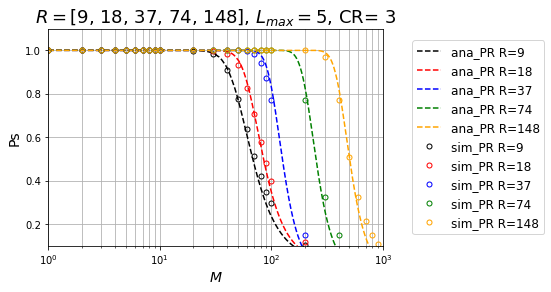

In [129]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.semilogx(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([1,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

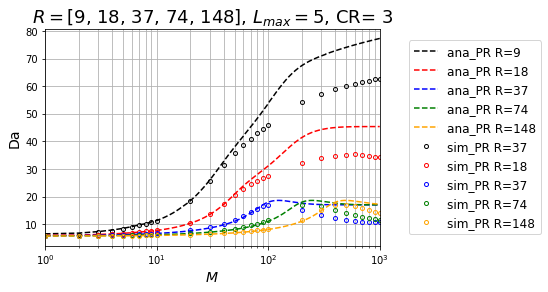

In [130]:
# plt.plot(m_list, da_list[0], color='black', label='ana R=9')
# plt.plot(m_list, da_list[1], color='red', label='ana R=18')
# plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.semilogx(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.xlim(1, sta_max)
plt.show()

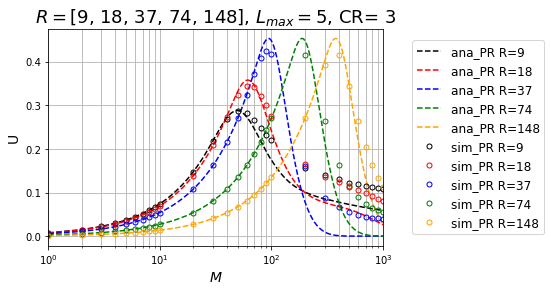

In [131]:
# plt.plot(m_list, u_list[0], color='black', label='ana R=9')
# plt.plot(m_list, u_list[1], color='red', label='ana R=18')
# plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.semilogx(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 3', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.xlim(1, sta_max)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

# CR=6

In [ ]:
R = [9,18,37,74,148]
Lmax = 5
# sta_max = 200
sta_max = 1000

m_list = [i for i in range(1, sta_max+1)]

ps_list = [ [0] * (sta_max) for _ in range(0, len(R))]
ps_list_PR  = [ [0] * (sta_max) for _ in range(0, len(R))]

da_list = [ [0] * (sta_max) for _ in range(0, len(R))]
da_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]

u_list = [ [0] * (sta_max) for _ in range(0, len(R))]
u_list_PR = [ [0] * (sta_max) for _ in range(0, len(R))]


for idx, r in enumerate(R):
    for sta in range (1, sta_max+1):
        Imax,Ps,Da,U,Tp = analytical(sta_amount=sta, RA_RU=r, Lmax=Lmax, TXOP=5.673, ocw_min=7, ocw_max=31, CR=6, step=4)
        ps_list_PR[idx][sta-1] = Ps
        da_list_PR[idx][sta-1] = Da
        u_list_PR[idx][sta-1] = U

In [ ]:
# Simulation (old -> m=200)
# m_list_simu = [(i+1)*10 for i in range(20)]
m_list_simu = np.concatenate([np.arange(1, 11, 1), np.arange(20, 110, 10), np.arange(200, 1100, 100)])

ps_list_simu_9 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998888888888889, 1.0, 0.9980500000000007, 0.9674333333333305, 0.8616750000000004, 0.6980000000000003, 0.5355833333333335, 0.41287142857142606, 0.31779999999999975, 0.25313333333333354, 0.20378999999999972, 0.061619999999999994, 0.03551000000000008, 0.023847499999999966, 0.017569999999999898, 0.013706666666666707, 0.011397142857142837, 0.00975, 0.008089999999999983, 0.00718599999999996]
da_list_simu_9 = [5.672999999999856, 6.25448249999986, 6.860547999999878, 7.781937749999947, 8.409655199999989, 8.986977499999988, 9.539554714285671, 10.296495000000021, 11.130504791666633, 11.642697900000039, 19.713182344736953, 27.9869665763776, 34.660951749786534, 39.619466032931804, 43.419130238110114, 46.795666356793845, 49.82514690254479, 52.69838976579044, 55.10534126377412, 68.11606833729336, 71.5403931759626, 73.19700521897447, 74.39391830053705, 75.19788484011153, 76.00698932284708, 76.55251409308202, 77.12108218747356, 77.53082220318043]
t_list_simu_9 = [0.06666666666666801, 0.13333333333333602, 0.19999999999999718, 0.26666666666667205, 0.3333333333333318, 0.39999999999999436, 0.46666666666665557, 0.5333333333333441, 0.5999333333333446, 0.6666666666666636, 1.3307333333333278, 1.934866666666661, 2.297800000000008, 2.326666666666674, 2.142333333333334, 1.92673333333333, 1.694933333333331, 1.5187999999999973, 1.3586000000000027, 0.8215999999999992, 0.7102000000000015, 0.6359333333333357, 0.5856666666666681, 0.548266666666668, 0.5318666666666672, 0.5200000000000002, 0.48539999999999933, 0.47906666666666575]
u_list_simu_9 = [0.007407407407407279, 0.014814814814814559, 0.02222222222222215, 0.029629629629629117, 0.0370370370370375, 0.0444444444444443, 0.051851851851851004, 0.059259259259258235, 0.06665925925926061, 0.074074074074075, 0.14785925925926102, 0.21498518518518678, 0.25531111111111204, 0.2585185185185187, 0.23803703703703763, 0.21408148148148168, 0.18832592592592587, 0.16875555555555521, 0.15095555555555557, 0.0912888888888889, 0.07891111111111121, 0.07065925925925932, 0.06507407407407412, 0.06091851851851861, 0.059096296296296286, 0.057777777777777685, 0.05393333333333343, 0.053229629629629675]
power_list_simu_9 = [1.0, 1.157, 1.3173333333333328, 1.5665, 1.741600000000003, 1.8900000000000001, 2.0462857142857205, 2.24775, 2.5271249999999985, 2.6494000000000035, 5.682983625730995, 10.21212436333115, 16.46131395812282, 25.125324721859318, 36.96894031261364, 51.32463095302585, 69.63935485870815, 89.84191646465679, 113.82743704196344, 395.0009179433118, 691.3796267112483, 1037.6095589599945, 1446.547273598621, 1851.1564833205998, 2224.2430710612985, 2621.0436452436447, 3189.8708413645168, 3613.1886252636136]


ps_list_simu_18 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9987000000000001, 0.9784750000000051, 0.9039200000000028, 0.7636666666666663, 0.6153142857142864, 0.47917500000000024, 0.36905555555555464, 0.28930000000000056, 0.06346500000000008, 0.033313333333333334, 0.02183999999999995, 0.015699999999999947, 0.01124666666666667, 0.008065714285714263, 0.005988749999999994, 0.0043533333333333184, 0.0030899999999999582]
da_list_simu_18 = [5.672999999999856, 5.933957999999861, 6.136294999999874, 6.382124999999911, 6.614717999999955, 6.934296999999919, 7.158515571428512, 7.386955125000014, 7.572194333333328, 7.940498100000036, 10.91144820000004, 14.589051492857152, 18.49493024473398, 22.158492755850713, 24.967410428596672, 27.054505908683687, 28.737818348858568, 30.331689520301623, 31.856206477435077, 41.78601492437801, 44.43599382724436, 45.121510033395055, 45.307199897001965, 45.353422404871296, 45.37222124862845, 45.38194936603156, 45.383999999998856, 45.38399999999888]
t_list_simu_18 = [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1.0, 1.125, 1.25, 2.5, 3.745125, 4.892375, 5.6495, 5.7275, 5.384, 4.79175, 4.151875, 3.61625, 1.586625, 1.24925, 1.092, 0.98125, 0.8435, 0.70575, 0.598875, 0.48975, 0.38625]
u_list_simu_18 = [0.0069444444444445785, 0.013888888888889157, 0.02083333333333324, 0.027777777777778314, 0.03472222222222164, 0.04166666666666648, 0.048611111111111965, 0.05555555555555663, 0.0625, 0.06944444444444328, 0.13888888888888656, 0.20806250000000232, 0.2717986111111094, 0.3138611111111112, 0.31819444444444495, 0.29911111111111116, 0.26620833333333344, 0.23065972222222253, 0.20090277777777757, 0.08814583333333326, 0.06940277777777769, 0.06066666666666671, 0.05451388888888902, 0.046861111111111166, 0.039208333333333414, 0.033270833333333354, 0.027208333333333362, 0.02145833333333335]
power_list_simu_18 = [1.0, 1.094, 1.1633333333333338, 1.2625, 1.3423999999999967, 1.4706666666666643, 1.544857142857147, 1.638, 1.708888888888883, 1.8600000000000008, 3.2540000000000058, 5.490994252873561, 8.76430198388619, 13.52527609946168, 20.4831200143775, 29.416898768467654, 41.416904938240755, 57.31543402045146, 76.02015100857768, 383.8323530250971, 740.9179715620963, 1144.5903663003674, 1588.0943126318089, 2289.5958891108926, 3403.921010101019, 4662.932380952378, 6621.043603896099, 9113.010714285716]


ps_list_simu_37 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99995, 0.9996200000000001, 0.9948666666666676, 0.9763999999999977, 0.9181875000000007, 0.8251777777777778, 0.693629999999999, 0.0557149999999999, 0.0041733333333333475, 0.00033500000000000023, 2.0000000000000005e-05, 1.6666666666666669e-06, 0.0, 0.0, 0.0, 0.0]
da_list_simu_37 = [5.672999999999856, 5.772277499999858, 5.930175999999868, 6.009125249999888, 6.095071199999907, 6.245027499999898, 6.398333571428481, 6.465092624999965, 6.569964333333286, 6.652159800000002, 7.80264420000004, 9.003429200000012, 10.303339922368487, 11.840259063724474, 13.558942024196774, 15.132859207472263, 16.58499434183273, 17.525227473101737, 18.039201557655918, 17.38897121229356, 16.78389547383302, 16.19261811023622, 16.073500000000003, 28.365000000000002, 28.365000000000002, 28.365000000000002, 28.365000000000002, 28.365000000000002]
t_list_simu_37 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 7.9996, 9.9962, 11.938400000000023, 13.669600000000056, 14.691000000000011, 14.853199999999996, 13.872600000000004, 2.2286000000000024, 0.2503999999999991, 0.026799999999999942, 0.0019999999999999996, 0.0002, 0.0, 0.0, 0.0, 0.0]
u_list_simu_37 = [0.005405405405405471, 0.010810810810810942, 0.016216216216216387, 0.021621621621621883, 0.02702702702702728, 0.032432432432432774, 0.03783783783783734, 0.043243243243243766, 0.048648648648649366, 0.05405405405405456, 0.10810810810810911, 0.16216216216216145, 0.21620540540540742, 0.2701675675675632, 0.3226594594594587, 0.3694486486486489, 0.3970540540540538, 0.4014378378378373, 0.37493513513513466, 0.060232432432432856, 0.006767567567567603, 0.0007243243243243224, 5.405405405405406e-05, 5.405405405405406e-06, 0.0, 0.0, 0.0, 0.0]
power_list_simu_37 = [1.0, 1.035, 1.0933333333333333, 1.1205, 1.1511999999999976, 1.208666666666667, 1.2628571428571462, 1.2915, 1.3286666666666571, 1.357600000000006, 1.8541999999999992, 2.483133333333335, 3.306818421052635, 4.510076292517002, 6.186028143401924, 8.222501246584896, 11.316046385940155, 15.263468859971187, 21.260423637893545, 444.04353074820915, 3416.9565666666676, 1134.424, 97.616, 13.8, 0.0, 0.0, 0.0, 0.0]


ps_list_simu_74 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999714285714285, 1.0, 0.9998888888888888, 0.9995100000000002, 0.697145, 0.20689666666666684, 0.056367499999999876, 0.015815999999999924, 0.0045183333333333135, 0.0011771428571428575, 0.0003874999999999979, 9.444444444444428e-05, 2.300000000000001e-05]
da_list_simu_74 = [5.672999999999856, 5.760931499999856, 5.7996969999998615, 5.860208999999873, 5.907862199999882, 5.971777999999878, 5.987446285714164, 6.0672734999999225, 6.136925333333246, 6.190944899999954, 6.71002440000002, 7.291506900000003, 7.819521375000055, 8.438474040000001, 9.080771099999996, 9.695435882773097, 10.35726701250005, 11.146453657575758, 11.853493723529265, 18.036633345609967, 17.980987338953856, 17.471302426049863, 17.024656656412755, 16.886947986732487, 16.612215116279003, 18.078791208791134, 15.828370370370372, 19.33977272727273]
t_list_simu_74 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 13.999600000000001, 16.0, 17.998, 19.990199999999998, 27.8858, 12.41379999999999, 4.509400000000004, 1.5815999999999988, 0.5421999999999985, 0.16479999999999995, 0.062000000000000235, 0.016999999999999973, 0.004600000000000002]
u_list_simu_74 = [0.0027027027027027354, 0.005405405405405471, 0.008108108108108194, 0.010810810810810942, 0.01351351351351364, 0.016216216216216387, 0.01891891891891867, 0.021621621621621883, 0.024324324324324683, 0.02702702702702728, 0.05405405405405456, 0.08108108108108072, 0.10810810810810911, 0.13513513513513292, 0.16216216216216145, 0.1891837837837858, 0.21621621621621823, 0.2432162162162219, 0.2701378378378335, 0.3768351351351354, 0.16775405405405397, 0.06093783783783786, 0.021372972972973015, 0.007327027027027064, 0.0022270270270270207, 0.0008378378378378331, 0.00022972972972972974, 6.216216216216216e-05]
power_list_simu_74 = [1.0, 1.033, 1.044666666666666, 1.067, 1.0843999999999985, 1.1059999999999994, 1.1120000000000008, 1.14075, 1.1682222222222178, 1.1862000000000037, 1.3840999999999997, 1.6235333333333335, 1.8536000000000021, 2.1648400000000017, 2.5137333333333314, 2.893957983193279, 3.339000000000001, 3.9410292929292967, 4.528508221750426, 20.927975438582294, 100.64471335206116, 413.50810954901004, 1715.5181221448133, 5931.125252380955, 7175.692499999999, 4704.012, 1634.132, 494.261]


ps_list_simu_148 = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9997200000000003, 0.954873333333343, 0.6943449999999997, 0.3945119999999998, 0.2076150000000003, 0.10767285714285672, 0.057146250000000086, 0.029641111111111226, 0.016071999999999986]
da_list_simu_148 = [5.672999999999856, 5.695691999999856, 5.733511999999859, 5.765186249999863, 5.790998399999869, 5.823334499999871, 5.841569142857015, 5.895665249999896, 5.913156999999894, 5.915237099999904, 6.228103049999988, 6.467219999999987, 6.748317150000013, 7.007403059999997, 7.291601449999991, 7.574832728571431, 7.844269837500042, 8.139494333333337, 8.415668580000004, 11.877261515599743, 15.964431607436875, 18.05264631537547, 18.29423139832767, 18.012917531021596, 17.664179450716308, 17.420979445328612, 17.29902348308819, 17.113146270616355]
t_list_simu_148 = [0.19999999999999718, 0.39999999999999436, 0.6000000000000113, 0.7999999999999887, 1.0, 1.2000000000000226, 1.4000000000000128, 1.5999999999999774, 1.7999999999999698, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0, 39.988799999999976, 57.29239999999996, 55.54759999999999, 39.45120000000001, 24.913799999999974, 15.074200000000001, 9.143399999999993, 5.335400000000002, 3.214400000000004]
u_list_simu_148 = [0.0013513513513513677, 0.0027027027027027354, 0.004054054054054097, 0.005405405405405471, 0.00675675675675682, 0.008108108108108194, 0.009459459459459335, 0.010810810810810942, 0.012162162162162342, 0.01351351351351364, 0.02702702702702728, 0.04054054054054036, 0.05405405405405456, 0.06756756756756646, 0.08108108108108072, 0.0945945945945956, 0.10810810810810911, 0.12162162162162446, 0.13513513513513292, 0.2701945945945903, 0.3871108108108117, 0.3753216216216215, 0.2665621621621618, 0.16833648648648636, 0.10185270270270254, 0.06177972972972979, 0.03605000000000001, 0.021718918918918882]
power_list_simu_148 = [1.0, 1.008, 1.0213333333333332, 1.0325, 1.041599999999999, 1.0536666666666663, 1.0594285714285725, 1.0785, 1.0846666666666647, 1.0866000000000013, 1.1985000000000015, 1.2858000000000052, 1.396949999999999, 1.497839999999999, 1.6154666666666677, 1.743657142857143, 1.867125000000002, 2.008111111111108, 2.144439999999997, 4.531751000373957, 9.614908455061046, 21.011865152418988, 46.64351830463393, 99.41857734131602, 203.88437397028454, 398.2951752850154, 794.7440224043854, 1511.0986616894868]

In [ ]:
# plt.plot(m_list, ps_list[0], color='black', label='ana R=9')
# plt.plot(m_list, ps_list[1], color='red', label='ana R=18')
# plt.plot(m_list, ps_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, ps_list[3], color='green', label='ana R=74')
# plt.plot(m_list, ps_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, ps_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, ps_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, ps_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, ps_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.semilogx(m_list, ps_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, ps_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, ps_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)


plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Ps", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.axis([11,sta_max,0.1,1.1]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

In [ ]:
# plt.plot(m_list, da_list[0], color='black', label='ana R=9')
# plt.plot(m_list, da_list[1], color='red', label='ana R=18')
# plt.plot(m_list, da_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, da_list[3], color='green', label='ana R=74')
# plt.plot(m_list, da_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, da_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, da_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, da_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, da_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.semilogx(m_list, da_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, da_list_simu_9, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=4)
plt.semilogx(m_list_simu, da_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=4)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("Da", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
plt.xlim(1,sta_max)

# plt.axis([10,sta_max,0,60]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.show()

In [ ]:
# plt.plot(m_list, u_list[0], color='black', label='ana R=9')
# plt.plot(m_list, u_list[1], color='red', label='ana R=18')
# plt.plot(m_list, u_list[2], color='blue', label='ana R=37')
# plt.plot(m_list, u_list[3], color='green', label='ana R=74')
# plt.plot(m_list, u_list[4], color='orange', label='ana R=148')

plt.semilogx(m_list, u_list_PR[0], linestyle = '--', color='black', label='ana_PR R=9')
plt.semilogx(m_list, u_list_PR[1], linestyle = '--', color='red', label='ana_PR R=18')
plt.semilogx(m_list, u_list_PR[2], linestyle = '--', color='blue', label='ana_PR R=37')
plt.semilogx(m_list, u_list_PR[3], linestyle = '--', color='green', label='ana_PR R=74')
plt.semilogx(m_list, u_list_PR[4], linestyle = '--', color='orange', label='ana_PR R=148')

plt.semilogx(m_list_simu, u_list_simu_9, label='sim_PR R=9', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='black', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_18, label='sim_PR R=18', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='red', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_37, label='sim_PR R=37', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='blue', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_74, label='sim_PR R=74', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='green', markersize=5)
plt.semilogx(m_list_simu, u_list_simu_148, label='sim_PR R=148', linestyle='None', marker='o', markerfacecolor='None', markeredgecolor='orange', markersize=5)

plt.title('$R = $' + str(R) +', $L_{max} = $' + str(Lmax) + ', CR= 6', fontsize = 18)
plt.xlabel("$M$", fontsize = 14)
plt.ylabel("U", fontsize = 14)
plt.grid(True, which="both")
plt.legend(loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize = 12)
# plt.axis([10,sta_max,0,0.35]) #x spacing,x max, y spcaing, y max
# plt.rcParams["figure.figsize"] = (8,6)
# plt.xticks(M_ticks)
# plt.yticks(fontsize = 14)
plt.xlim(1,sta_max)

plt.show()